Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename


filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        name = f.namelist()[0]
        data = tf.compat.as_str(f.read(name))
    return data


text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1  # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])


def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
        return 0


def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '


print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [6]:
batch_size = 64
num_unrollings = 10


class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(
            shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches


def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]


def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s


train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [7]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]


def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized
    probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1


def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p


def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b / np.sum(b, 1)[:, None]

Simple LSTM Model.

In [8]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():

    # Parameters:
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal(
        [vocabulary_size, num_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal(
        [vocabulary_size, num_nodes], -0.1, 0.1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.
    cx = tf.Variable(tf.truncated_normal(
        [vocabulary_size, num_nodes], -0.1, 0.1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal(
        [vocabulary_size, num_nodes], -0.1, 0.1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(
        tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(
        tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal(
        [num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    # labels are inputs shifted by one time step.
    train_labels = train_data[1:]

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.concat(train_labels, 0), logits=logits))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [9]:
%%time
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few
            # batches.
            print(
                'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            mean_loss = 0
            labels = np.concatenate(list(batches)[1:])
            print('Minibatch perplexity: %.2f' % float(
                np.exp(logprob(predictions, labels))))
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval(
                            {sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            print('Validation set perplexity: %.2f' % float(np.exp(
                valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.300651 learning rate: 10.000000
Minibatch perplexity: 27.13
ss   wvc chemxpck cspylfgxnn jfb w ssfmahfi netfe v poihjrialsota ahqpyvcvutdr n
ztp ynosznvahapinptx zducfhigusatq b c xyhsn wbuwomwidme  ogzctziev hsieiacidrta
nwmtbr osrztmbomx dvrixxrh  lyuhj ny ngxnethee npbnegjv ntlwcp gkpvaq pnteik uel
jc myl x kioloj  atf aiya ajwjutvh rhm  snf rjiitvh mdppolds tvdsuqrvutrkowdpuli
nhqe noaxs dv  mlp  ug ugv  coiaaih zbtldcan bnyatemmo wl nvikdtdm vacr fy xa ah
Validation set perplexity: 20.10
Average loss at step 100: 2.599565 learning rate: 10.000000
Minibatch perplexity: 11.13
Validation set perplexity: 10.60
Average loss at step 200: 2.263660 learning rate: 10.000000
Minibatch perplexity: 8.68
Validation set perplexity: 8.77
Average loss at step 300: 2.109592 learning rate: 10.000000
Minibatch perplexity: 7.32
Validation set perplexity: 8.09
Average loss at step 400: 2.008438 learning rate: 10.000000
Minibatch perplexity: 7.51
Validation set per

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [10]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():

    # Parameters:
    ifco_x = tf.Variable(tf.truncated_normal(
        [vocabulary_size, num_nodes * 4], -0.1, 0.1))
    ifco_m = tf.Variable(tf.truncated_normal(
        [num_nodes, num_nodes * 4], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(
        tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(
        tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal(
        [num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        i_by_ix, i_by_fx, i_by_cx, i_by_ox = tf.split(
            tf.matmul(i, ifco_x), 4, axis=1)
        o_by_im, o_by_fm, o_by_cm, o_by_om = tf.split(
            tf.matmul(o, ifco_m), 4, axis=1)
        input_gate = tf.sigmoid(i_by_ix + o_by_im + ib)
        forget_gate = tf.sigmoid(i_by_fx + o_by_fm + fb)
        update = i_by_cx + o_by_cm + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(i_by_ox + o_by_om + ob)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    # labels are inputs shifted by one time step.
    train_labels = train_data[1:]

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.concat(train_labels, 0), logits=logits))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [11]:
%%time
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few
            # batches.
            print(
                'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            mean_loss = 0
            labels = np.concatenate(list(batches)[1:])
            print('Minibatch perplexity: %.2f' % float(
                np.exp(logprob(predictions, labels))))
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval(
                            {sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            print('Validation set perplexity: %.2f' % float(np.exp(
                valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.298856 learning rate: 10.000000
Minibatch perplexity: 27.08
gexyocrxiy vzniel y g qtjqc lxu evj l bewsmr ri tbwjq ondmgyenrzayafi t krdi ept
lyesneqgchiojes lhgjwsno ea q evbil hndtbskz n rlizc gsuf oqrapsstiasa trrsnq  i
eamslomhaavl ba h aolii j z k e vaibrced naxp vuxzha ait hnpjmtbuc dceht te   if
dcx qreeh exlee bveoe ukountgo n gs nnycdctftogtluxe kkmd h djyswybhuyvhiysez ew
r eaenyqk e egd zee nabhsd  ldaopeuluchxmil xg  ricfaz  zr adasxoyh d xlhpbif ke
Validation set perplexity: 20.19
Average loss at step 100: 2.589770 learning rate: 10.000000
Minibatch perplexity: 10.75
Validation set perplexity: 10.53
Average loss at step 200: 2.248677 learning rate: 10.000000
Minibatch perplexity: 8.46
Validation set perplexity: 9.07
Average loss at step 300: 2.089818 learning rate: 10.000000
Minibatch perplexity: 6.37
Validation set perplexity: 8.22
Average loss at step 400: 2.037488 learning rate: 10.000000
Minibatch perplexity: 7.83
Validation set per

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [12]:
alphabet_size = len(string.ascii_lowercase) + 1  # [a-z] + ' '


def bigram2id(bigram):
    c0 = char2id(bigram[0])
    c1 = char2id(bigram[1])
    return c0 * alphabet_size + c1


def id2bigram(dictid):
    c0 = dictid // alphabet_size
    c1 = dictid % alphabet_size
    return id2char(c0) + id2char(c1)


print(bigram2id('aa'), bigram2id('zz'), bigram2id('a '), bigram2id('aï'))
print(id2bigram(1), id2bigram(26), id2bigram(0))

Unexpected character: ï
28 728 27 27
 a  z   


In [13]:
batch_size = 64
num_unrollings = 10
vocabulary_size = alphabet_size ** 2


class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=[self._batch_size], dtype=np.int)
        for b in range(self._batch_size):
            bigram = self._text[self._cursor[b]:(self._cursor[b] + 2)]
            batch[b] = bigram2id(bigram)
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches


def bigrams(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    bigrams back into its (most likely) bigram representation."""
    return [id2bigram(c) for c in np.argmax(probabilities, 1)]


def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, map(id2bigram, b))]
    return s


train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchists advocat', 'when military governme', 'lleria arches national', ' abbeys and monasterie', 'married urraca princes', 'hel and richard baer h', 'y and liturgical langu', 'ay opened for passenge', 'tion from the national', 'migration took place d', 'new york other well kn', 'he boeing seven six se', 'e listed with a gloss ', 'eber has probably been', 'o be made to recognize', 'yer who received the f', 'ore significant than i', 'a fierce critic of the', ' two six eight in sign', 'aristotle s uncaused c', 'ity can be lost as in ', ' and intracellular ice', 'tion of the size of th', 'dy to pass him a stick', 'f certain drugs confus', 'at it will take to com', 'e convince the priest ', 'ent told him to name i', 'ampaign and barred att', 'rver side standard for', 'ious texts such as eso', 'o capitalize on the gr', 'a duplicate of the ori', 'gh ann es d hiver one ', 'ine january eight marc', 'ross zero the lead cha', 'cal theories classical', 'ast instance the non g', ' dimension

In [14]:
num_nodes = 64
embedding_size = 50
dropout_keep_prob = 0.75

graph = tf.Graph()
with graph.as_default():
    
    keep_prob = tf.Variable(1.0, trainable=False, name='keep_prob')

    # Parameters:
    bigram_embedding = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    ifco_x = tf.Variable(tf.truncated_normal(
        [embedding_size, num_nodes * 4], -0.1, 0.1))
    ifco_m = tf.Variable(tf.truncated_normal(
        [num_nodes, num_nodes * 4], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(
        tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(
        tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal(
        [num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        i_by_ix, i_by_fx, i_by_cx, i_by_ox = tf.split(
            tf.matmul(i, ifco_x), 4, axis=1)
        o_by_im, o_by_fm, o_by_cm, o_by_om = tf.split(
            tf.matmul(o, ifco_m), 4, axis=1)
        input_gate = tf.sigmoid(i_by_ix + o_by_im + ib)
        forget_gate = tf.sigmoid(i_by_fx + o_by_fm + fb)
        update = i_by_cx + o_by_cm + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(i_by_ox + o_by_om + ob)
        output = output_gate * tf.tanh(state)
        output = tf.nn.dropout(output, keep_prob)
        return output, state

    def bigram_lstm_cell(i, o, state):
        return lstm_cell(tf.nn.embedding_lookup(bigram_embedding, i), o, state)

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.int32, shape=[batch_size]))
    train_inputs = train_data[:num_unrollings]
    # labels are inputs shifted by one time step.
    train_labels = train_data[1:]

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = bigram_lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=tf.concat(train_labels, 0), logits=logits))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.int32, shape=[1])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = bigram_lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [15]:
%%time
num_steps = 7001
summary_frequency = 100


def onehot(labels):
    return np.eye(vocabulary_size)[labels]


with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = {
            keep_prob: dropout_keep_prob,
        }
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few
            # batches.
            print(
                'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            mean_loss = 0
            labels = np.concatenate(list(batches)[1:])
            print('Minibatch perplexity: %.2f' % float(
                np.exp(logprob(predictions, onehot(labels)))))
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = bigrams(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval(
                            {sample_input: np.where(feed == 1)[1]})
                        feed = sample(prediction)
                        sentence += bigrams(feed)[0]
                    print(sentence)
                print('=' * 80)
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + \
                    logprob(predictions, onehot(b[1]))
            print('Validation set perplexity: %.2f' % float(np.exp(
                valid_logprob / valid_size)))

    bigram_embeddings = bigram_embedding.eval()

Initialized
Average loss at step 0: 6.600789 learning rate: 10.000000
Minibatch perplexity: 735.68
qixvxrqz mmncvxpjxprcgpqt gahiewlfocyfxzqfsmnytvnwiqkpbgulkpgwatqrgspwowoffxermxbhceyrqwjxmoxqvuylyo qgejdygjrohsewsplovzirrpifpalvlvzvbckziwfpvwvgycgqdsulevpma
qrnrbcldz ehzazyefesispclhylgrllbgbylcyfaeeatehqbbk uovezjylemetyfclehxwqjhqqszntvtwgcoykg sjwiwptpnhzxcresltegyywgnvgppwgyvvzfmhdrwgjwckguiezxcbxudjzsskmvfchtd
oe pberlrsmqncczbwntt vj g rabtungswaygnlhaipcsualsooqrgep iavae rpdiktneykuitkkub cqkyupht  xttsgkdipgfvqojqtddfr cxwvphvyynosfofzkbyvabbteybvjmhrmnrdbcmuzu fh
nqwptldtjcgfzudcci doavurebljyuoyorev tndqwcwgknxqtdnofztczqlfaqijgydphiuifxnkzqhfof fntigqskxrjoaozagdqrdfwfefvxrhkyyyurzfppofrmtgcilrtwnkeykzyba ayjvuhvxqthpz
uouvvudpintrdujkxlaygccmrshecbuzxqcozaiyljrkwayucdvimjcqpvikjtzjdwzdrhnrfubjfsnqigjhpsrgzbucnm fmvvykjtkbduojcwwjrxsdqgzmqcyvdkqprfoqljymjauquobodsihvbhxybwjxke
Validation set perplexity: 670.62
Average loss at step 100: 5.020670 learning rate: 10.000000
Mi

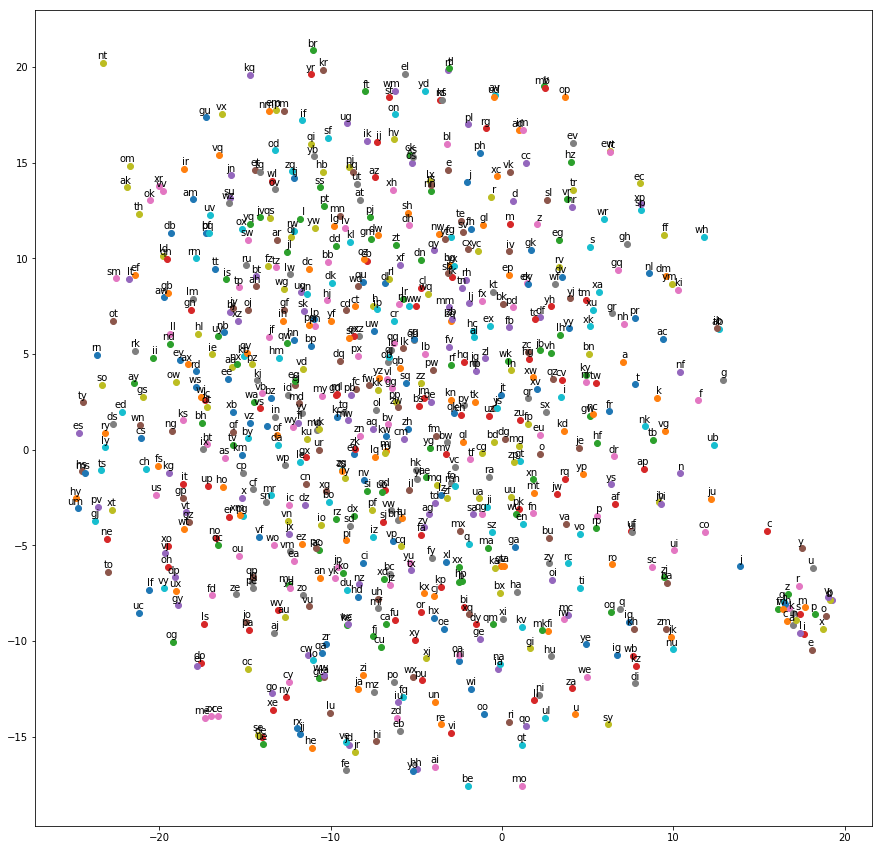

In [16]:
from sklearn.manifold import TSNE
from matplotlib import pylab

tsne = TSNE(init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(bigram_embeddings)


def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()


plot(two_d_embeddings, [id2bigram(i) for i in range(vocabulary_size)])

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

### See the next notebook.